# Create embeddings of detected faces and calculate similarity

Some small test for creating embeddings of faces to detect similar faces,
before testing this on our archive of several terabytes of fotos.

In [167]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib import patches
import numpy as np
import typing
import pandas as pd
import itertools
from scipy.spatial import distance

3 test images:
* Carolien on her own, having a drink
* Carolien on her own, again having a drink, but my face is reflected on some glass wall
* Carolien with her godchild on her lap, with their faces very close to each other

In [168]:
img1_name: str = 'test_files/test-image-carolien-montreux-2018.jpg'
img2_name: str = 'test_files/test-image-carolien-geneva-2018.jpg'
img3_name: str = 'test_files/test-image-carolien-bern-2018-with-child.jpg'

all_image_names: typing.List[str] = [img1_name, img2_name, img3_name]

Show the test images:

<Figure size 900x300 with 0 Axes>

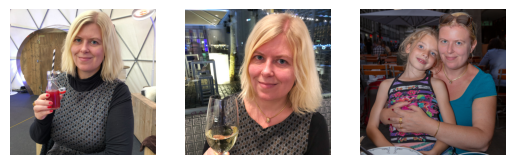

In [169]:
def show_images_in_row(filenames: typing.List[str]) -> None:
  """ show multiple images in a row """
  plt.figure(figsize=(len(filenames)*3., 3.))
  _, _axes = plt.subplots(1, len(filenames))
  axes: typing.List[Axes] = typing.cast(typing.List[Axes], _axes)
  for i, filename in enumerate(filenames):
    axes[i].set_axis_off()
    img: np.ndarray = plt.imread(filename)
    axes[i].imshow(img)

show_images_in_row(all_image_names)

The DeepFace.represent() method returns a quite weird datastructure.

=> wrap it with some object as it's not that convenient to work with a list of dicts that contains both dicts and lists.

In [170]:
class EmbeddingOfFaceWrapper:
  """ wrap the result of the DeepFace.represent call so you don't have to parse a dict containing other dicts and lists """
  def __init__(self, represent_retval: typing.Dict[str,typing.Any]) -> None:
    self.embedding: typing.List[float] = represent_retval['embedding']
    self.facial_area: typing.Dict[str,int] = represent_retval['facial_area']
    self.face_confidence: np.float64 = represent_retval['face_confidence']

def wrap_embeddings(extracted_embeddings: typing.List[typing.Dict[str,typing.Any]]) -> typing.List[EmbeddingOfFaceWrapper]:
  """ convert the list of dicts of extracted faces into more convenient objects """
  return [EmbeddingOfFaceWrapper(x) for x in extracted_embeddings]

As a test, get the embeddings of just a single image with the default model and backend:

In [171]:
embedding_objs: typing.List[EmbeddingOfFaceWrapper] = wrap_embeddings(DeepFace.represent(img_path = img3_name))
for detected_embedding in embedding_objs:
  print(f"Length of embedding: {len(detected_embedding.embedding)}")
  facial_area: typing.Dict[str,int] = detected_embedding.facial_area
  print(f"Face detected at {facial_area}")
  face_confidence: np.float64 = detected_embedding.face_confidence
  print(f"Face was detected with confidence {face_confidence}")

Length of embedding: 4096
Face detected at {'x': 519, 'y': 132, 'w': 264, 'h': 264}
Face was detected with confidence 10.562721127585974


The represent() method has some optional parameters to override the default models:
* The 'backend' is used to detect the face. It basically returns the location of the face within the image and a confidence value.
* The 'model' is used to calculate the embedding of a detected face.

From previous tests, I know that the retinaface backend is much better at detecting faces than the default opencv backend.

Check the number of dimensions of the embedding vector for a couple of models:

In [172]:
model_names: typing.List[str] = ['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'SFace']
backend: str = 'retinaface'
array: np.ndarray = np.zeros((len(model_names), 4), dtype='<U10')


for i, model_name in enumerate(model_names):
  array[i, 0] = model_name
  array[i, 1] = backend
  embedding_objs: typing.List[typing.Dict[str,typing.Any]] = DeepFace.represent(img_path = img3_name, model_name=model_name, detector_backend=backend)
  array[i, 2] = len(embedding_objs)
  first_embedding: typing.List[float] = embedding_objs[0]['embedding']
  array[i, 3] = len(first_embedding)

df = pd.DataFrame(array.tolist(), columns=['Model name', 'Backend', 'Number of detected faces', 'Number of dimensions'])
df.style.set_table_styles([{"selector":"tbody tr:nth-child(even)","props":[("background-color","lightgrey")]}])
display(df.style)


Let's the model VGG-Face but with the retinaface backend. List all the faces in the test images:

In [173]:
class FaceInfo:
  """ The embedding and some info about a certain face in a certain image """
  def __init__(self, img_name: str, face_number: int, embedding_info: EmbeddingOfFaceWrapper):
    """ face_number: the number of the face within the image as there might be multiple faces on an image """
    self.img_name: str = img_name
    self.face_number: int = face_number
    self.embedding_info: EmbeddingOfFaceWrapper = embedding_info

  def __repr__(self) -> str:
    return f"Face {self.face_number} in image {self.img_name} with embedding of size {len(self.embedding_info.embedding)}" \
    + f" at {self.embedding_info.facial_area} with confidence {self.embedding_info.face_confidence}"

all_faces: typing.List[FaceInfo] = []

model_name = "ArcFace"
backend = "retinaface"
for img_name in all_image_names:
  embedding_objs: typing.List[EmbeddingOfFaceWrapper] = wrap_embeddings(DeepFace.represent(img_path = img_name, model_name=model_name, detector_backend=backend))
  for face_number, embedding_obj in enumerate(embedding_objs):
    face_info = FaceInfo(img_name, face_number, embedding_obj)
    all_faces.append(face_info)

for face in all_faces:
  print(face)

Face 0 in image test_files/test-image-carolien-montreux-2018.jpg with embedding of size 512 at {'x': 423, 'y': 90, 'w': 242, 'h': 346} with confidence 0.9995160102844238
Face 0 in image test_files/test-image-carolien-geneva-2018.jpg with embedding of size 512 at {'x': 444, 'y': 155, 'w': 342, 'h': 487} with confidence 0.9991294741630554
Face 1 in image test_files/test-image-carolien-geneva-2018.jpg with embedding of size 512 at {'x': 42, 'y': 246, 'w': 54, 'h': 66} with confidence 0.9645575881004333
Face 0 in image test_files/test-image-carolien-bern-2018-with-child.jpg with embedding of size 512 at {'x': 547, 'y': 111, 'w': 221, 'h': 303} with confidence 0.9995571970939636
Face 1 in image test_files/test-image-carolien-bern-2018-with-child.jpg with embedding of size 512 at {'x': 349, 'y': 188, 'w': 201, 'h': 240} with confidence 0.9991269707679749


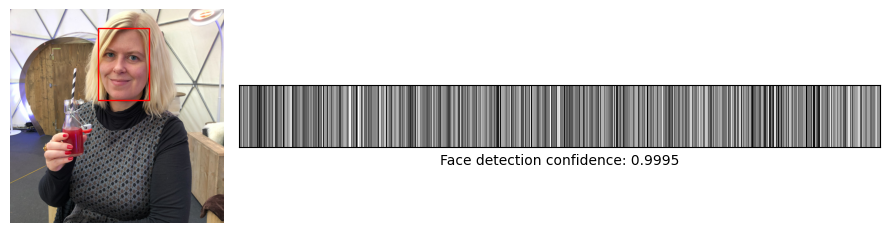

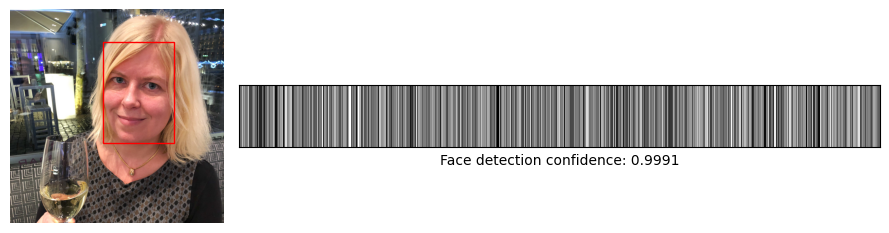

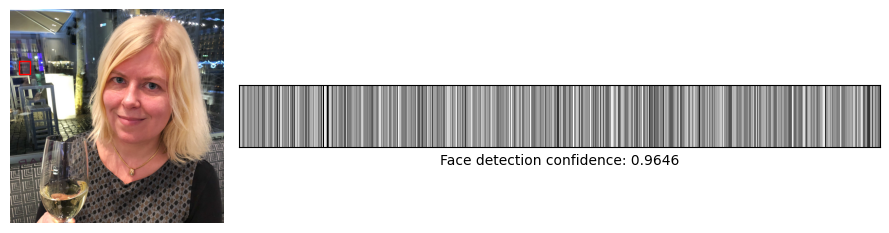

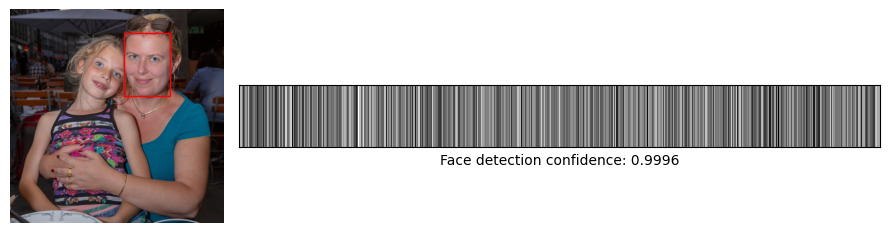

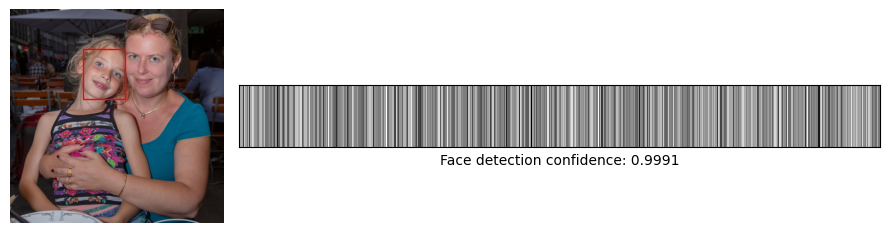

In [174]:
def show_detected_face_with_embedding(face_info: FaceInfo) -> None:
  """ show detected face with a heatmap of the embedding """
  fig: Figure = plt.figure(figsize=(9., 3.))
  gs: GridSpec = GridSpec(1, 2, width_ratios=[1, 3])

  # The image with the detected face area
  ax1: Axes = fig.add_subplot(gs[0, 0])
  ax1.set_axis_off()
  img: np.ndarray = plt.imread(face_info.img_name)
  ax1.imshow(img)
  face_area: typing.Dict[str,int] = face_info.embedding_info.facial_area
  rect = patches.Rectangle((face_area['x'], face_area['y']), face_area['w'], face_area['h'], linewidth=1, edgecolor='r', facecolor='none')
  ax1.add_patch(rect)

  # The embedding as some heatmap
  ax2: Axes = fig.add_subplot(gs[0, 1])
  embedding = face.embedding_info.embedding
  # extend the one dimensional list a bit so it's easier to see
  result_array = np.tile(np.array(embedding), (50, 1))
  ax2.imshow(result_array, cmap='gray', interpolation='nearest')
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xlabel(f"Face detection confidence: {face.embedding_info.face_confidence:.4f}")
  plt.tight_layout()


for face in all_faces:
  show_detected_face_with_embedding(face)

For each combination of 2 faces, calculate the similarity with the cosine distance.

A distance of 0 means 100% similarity, while a distance of 2 means that the vectors are opposites so no similarity at all.

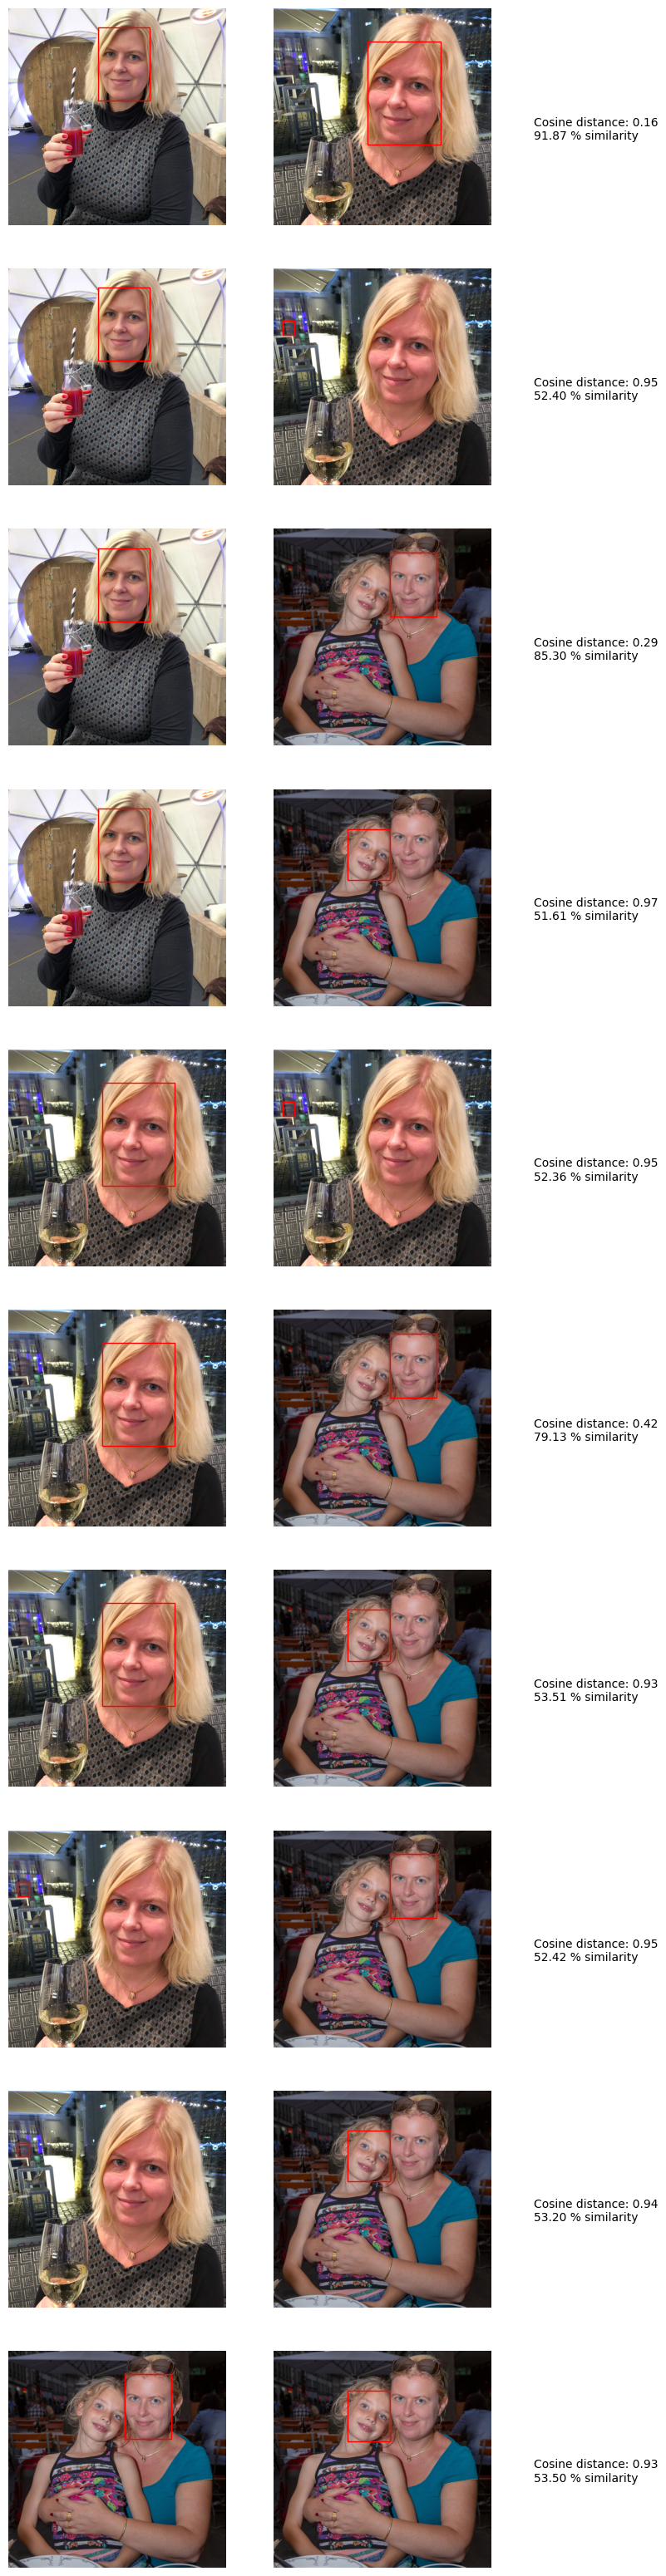

In [175]:
def similarity_as_percentage(number: float):
    """ Input: output of distance function in the range 0 to 2 """
    retval = ((2. - number) * 100.) / 2.
    return retval

all_combinations: typing.List[typing.Tuple[FaceInfo, FaceInfo]] = list(itertools.combinations(all_faces, 2))

fig: Figure = plt.figure(figsize=(10., 4. * len(all_combinations)))
gs: GridSpec = GridSpec(len(all_combinations), 3, width_ratios=[2, 2, 1])

for i, combination in enumerate(all_combinations):
  face1: FaceInfo = combination[0]
  face2: FaceInfo = combination[1]

  # Show face 1
  ax1: Axes = fig.add_subplot(gs[i, 0])
  ax1.set_axis_off()
  img: np.ndarray = plt.imread(face1.img_name)
  ax1.imshow(img)
  face_area: typing.Dict[str,int] = face1.embedding_info.facial_area
  rect = patches.Rectangle((face_area['x'], face_area['y']), face_area['w'], face_area['h'], linewidth=1, edgecolor='r', facecolor='none')
  ax1.add_patch(rect)

  # Show face 2
  ax2: Axes = fig.add_subplot(gs[i, 1])
  ax2.set_axis_off()
  img: np.ndarray = plt.imread(face2.img_name)
  ax2.imshow(img)
  face_area: typing.Dict[str,int] = face2.embedding_info.facial_area
  rect = patches.Rectangle((face_area['x'], face_area['y']), face_area['w'], face_area['h'], linewidth=1, edgecolor='r', facecolor='none')
  ax2.add_patch(rect)

  # Calculate & show the distance
  ax3: Axes = fig.add_subplot(gs[i,2])
  ax3.set_axis_off()
  cosine_distance: float = float(distance.cosine(face1.embedding_info.embedding, face2.embedding_info.embedding))
  text: str = f"Cosine distance: {cosine_distance:.2f}\n{similarity_as_percentage(cosine_distance):.2f} % similarity"
  
  ax3.text(0., 0.5, text, ha="left", va="top")


The 3 detected faces of Carolien have at least 79 % similarity.
When one of her detected faces is compared with a different person, similarity drops to +/- 50%.